In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import env_basketball

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn

In [7]:
env = env_basketball.BasketballEnv(config={'n_offensive_players': 5, 'n_defensive_players': 5})
state = env.reset()

for t in range(240):
    action = env.action_space.sample()
    action = env_basketball.get_random_action(env, env.state)
    state, reward, done, info = env.step(action)
    


In [8]:
env.render_episode(mode='file', tqdm=tqdm, filename='temp.gif')

  0%|          | 0/241 [00:00<?, ?it/s]

In [87]:
ani, vid = env.render_episode(mode='vid', tqdm=tqdm)
vid

  0%|          | 0/51 [00:00<?, ?it/s]

In [4]:
env = env_basketball.BasketballEnv(config={'n_offensive_players': 5, 'n_defensive_players': 5})
state = env.reset()

for player in env.players_all:
    vel = torch.randn(2)
    vel = vel/vel.norm()*6.7
    # vel = vel/vel.norm()*1.0
    player.body.velocity = tuple(vel.numpy())

for t in range(240):
    action = env.action_space.sample()
    state, reward, done, info = env.step(env_basketball.get_random_action(env, env.state))


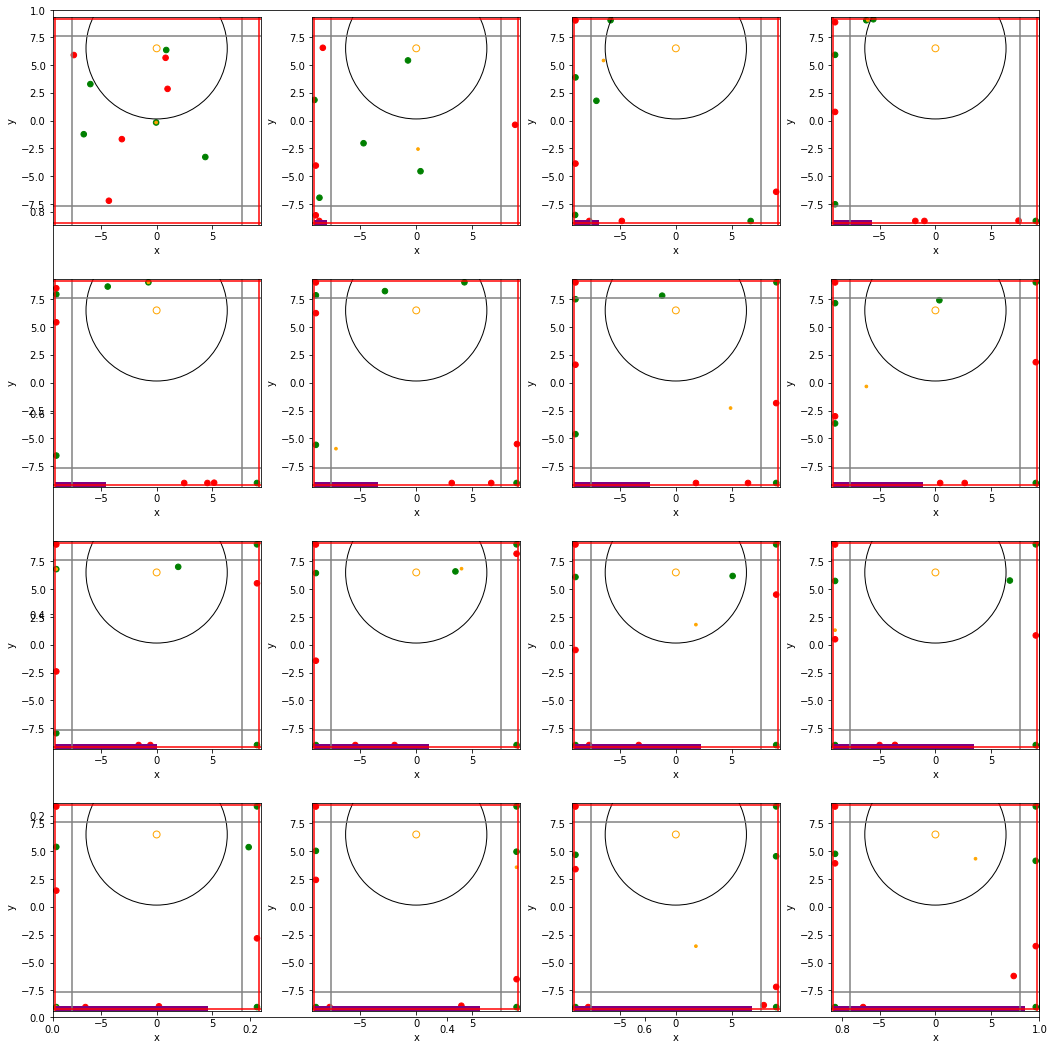

In [26]:
fig, ax = plt.subplots(figsize=(15, 15))
fig = env.render_episode(mode='grid', fig=fig, ax=ax, nrows=4, ncols=4)

In [27]:
ani, vid = env.render_episode(mode='vid', tqdm=tqdm)
vid

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

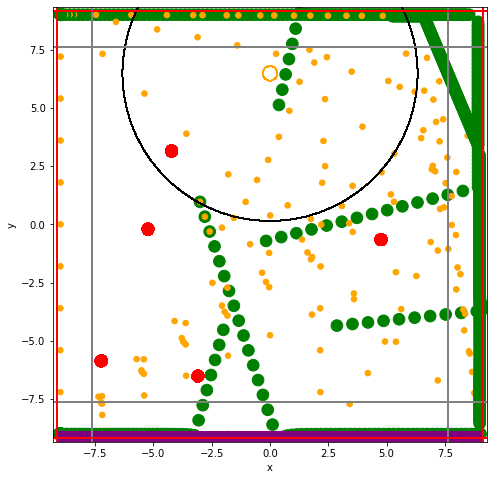

In [24]:
fig = env.render_episode(mode='overlay', tqdm=tqdm)

In [394]:
from ppp.ppp_hc import PPPHC

In [395]:
env = env_basketball.BasketballEnv(config={'n_offensive_players': 10, 'n_defensive_players': 10, 'thickness_3_point': 1.})
state = env.reset()
env.players_offense[0].body.position = (0, 5)
env.players_defense[0].body.position = (0, 6)
env.state = env.get_state()
p = env.ppp_calc

0.961230993270874

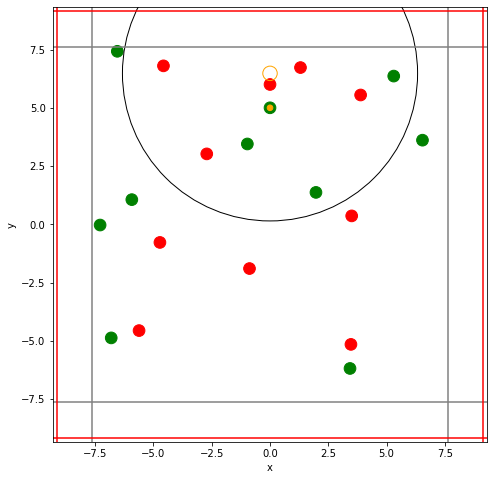

In [396]:
env.render()
env.ppp_calc.evaluate_ppp()

<AxesSubplot:xlabel='x', ylabel='y'>

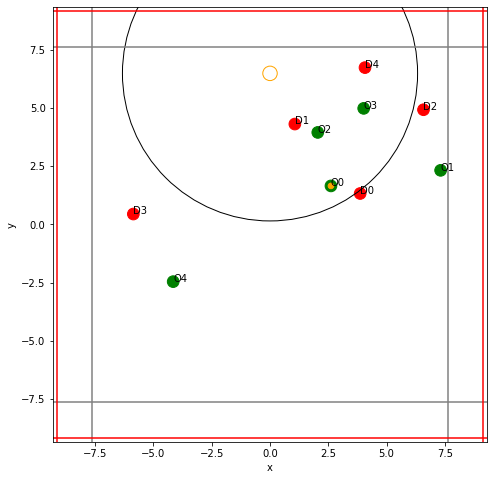

In [20]:
env = env_basketball.BasketballEnv(config={'n_offensive_players': 5, 'n_defensive_players': 5})
state = env.reset()
env.render(player_names=True)
# [f"{i}: {pppi.item():.03f}" for i, pppi in enumerate(ppp)]

In [399]:
pos_dp = torch.from_numpy(env.state['posvels'][len(env.players_offense):, 0, :])

a = env.ppp_calc.points_per_possession(v[..., None, :], pos_dp)[..., 0]

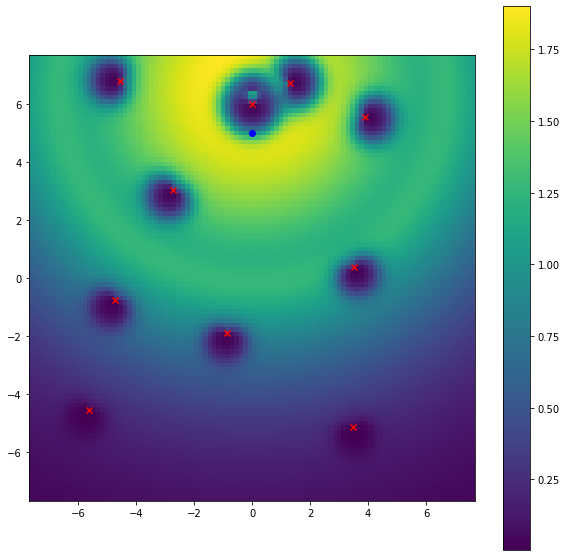

In [400]:
plt.figure(figsize=(10, 10))

plt.gca().set_aspect('equal')
plt.pcolormesh(x, y, a)
plt.colorbar()
plt.scatter(*pos_dp.T.numpy(), marker='x', color='r')
plt.scatter(*env.get_state()['posvels'][0, 0], marker='o', color='blue')

In [7]:
p = env.ppp_calc

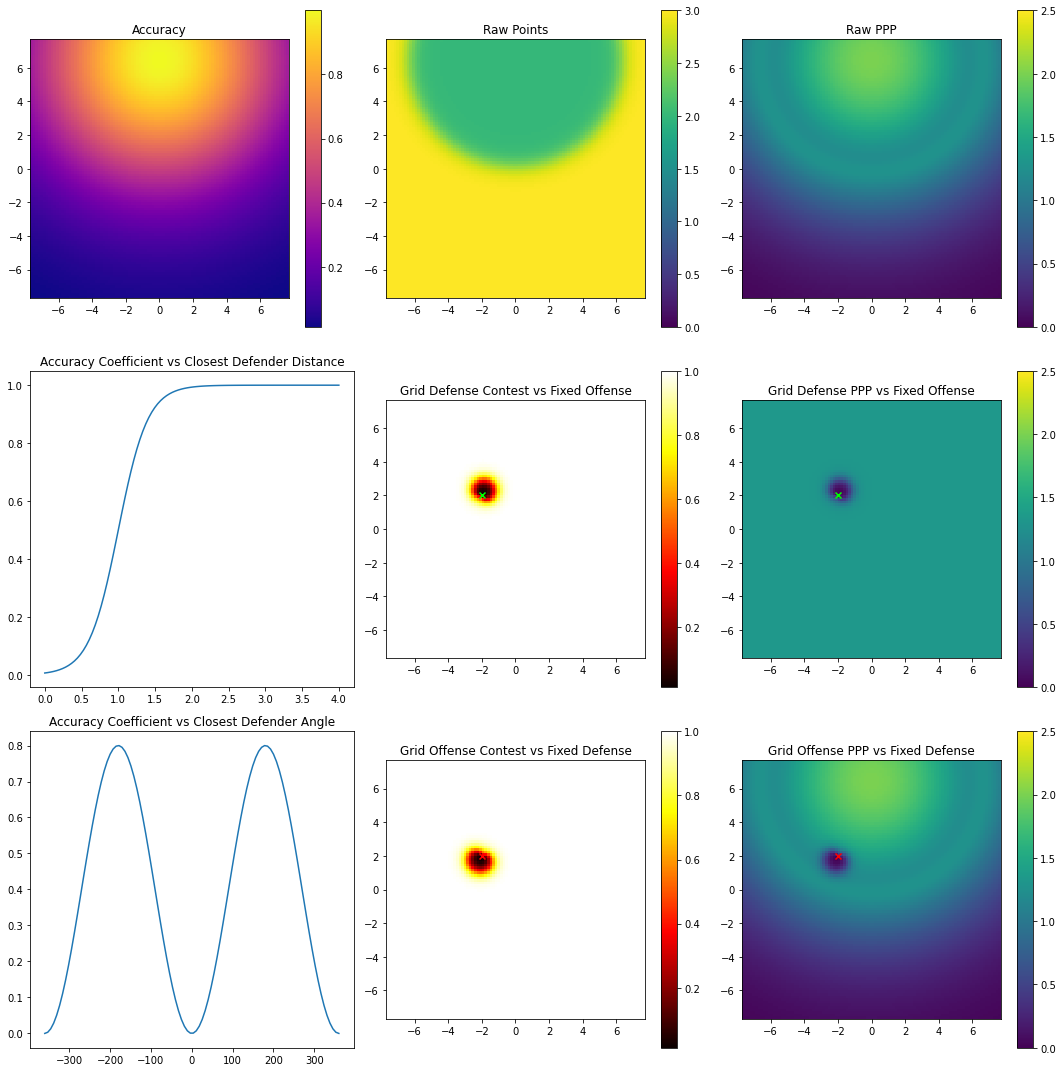

In [9]:
xmin, ymin, xmax, ymax = env.config['out_of_bounds']
resolution = 100
x = torch.linspace(xmin, xmax, resolution)
y = torch.linspace(ymin, ymax, resolution)
x, y = torch.meshgrid(x, y, indexing='ij')
v = torch.stack([x, y], dim=-1)

plt.figure(figsize=(15, 15), facecolor='white')

plt.subplot(331)
plt.gca().set_aspect('equal')
z = p.raw_accuracy(v)
plt.pcolormesh(x, y, z, cmap='plasma')
plt.colorbar()
plt.title('Accuracy')

plt.subplot(332)
plt.gca().set_aspect('equal')
z = p.raw_points(v)
plt.pcolormesh(x, y, z, vmin=0., vmax=3)
plt.colorbar()
plt.title('Raw Points')

plt.subplot(333)
plt.gca().set_aspect('equal')
z = p.raw_accuracy(v)*p.raw_points(v)
plt.pcolormesh(x, y, z, vmin=0., vmax=2.5)
plt.colorbar()
plt.title('Raw PPP')


plt.subplot(334)
d = torch.linspace(0, 4., 100)
cont = p.raw_contest_distance(d)
plt.plot(d.numpy(), cont.numpy())
plt.title('Accuracy Coefficient vs Closest Defender Distance')

plt.subplot(337)
d = torch.linspace(-2*np.pi, 2*np.pi, 100)
cont = p.raw_contest_angle(d)
plt.plot(d.numpy()*180./np.pi, cont.numpy())
plt.title('Accuracy Coefficient vs Closest Defender Angle')

pos_op = torch.tensor([-2, 2.])

plt.subplot(335)
cont = p.contest(pos_op, v)
plt.pcolormesh(x.numpy(), y.numpy(), cont.numpy(), cmap='hot')#, vmin=0, vmax=1)
plt.colorbar()
plt.scatter(*pos_op, marker='x', color='lime')
plt.gca().set_aspect('equal')
plt.title('Grid Defense Contest vs Fixed Offense')

plt.subplot(336)
ppp = p.points_per_possession(pos_op, v[:, :, None, :])[:, :, 0]
plt.pcolormesh(x.numpy(), y.numpy(), ppp.numpy(), vmin=0., vmax=2.5)
plt.colorbar()
plt.scatter(*pos_op, marker='x', color='lime')
plt.gca().set_aspect('equal')
plt.title('Grid Defense PPP vs Fixed Offense')

pos_dp = torch.tensor([-2, 2.])

plt.subplot(338)
cont = p.contest(v, pos_dp)
plt.pcolormesh(x.numpy(), y.numpy(), cont.numpy(), cmap='hot')#, vmin=0, vmax=1)
plt.colorbar()
plt.scatter(*pos_dp, marker='x', color='r')
plt.gca().set_aspect('equal')
plt.title('Grid Offense Contest vs Fixed Defense')

plt.subplot(339)
ppp = p.points_per_possession(v[:, :, None, :], pos_dp)[:, :, 0]
plt.pcolormesh(x.numpy(), y.numpy(), ppp.numpy(), vmin=0., vmax=2.5)
plt.colorbar()
plt.scatter(*pos_dp, marker='x', color='r')
plt.gca().set_aspect('equal')
plt.title('Grid Offense PPP vs Fixed Defense')

plt.tight_layout()

plt.show()

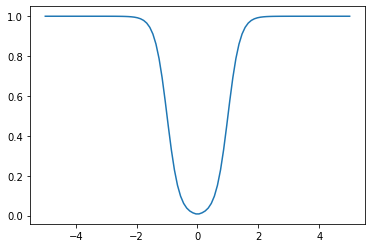

In [374]:
x = torch.linspace(-5, 5, 100)
weight = torch.tanh(3*x.abs()/7.62)
contest_distance = env.ppp_calc.raw_contest_distance(x.abs())
contest_directional = env.ppp_calc.raw_contest_distance(x.sign()*np.pi)
contest = weight*contest_distance+(1-weight)*contest_directional
# plt.plot(x, contest)
# plt.plot(x, weight)
plt.plot(x, contest_distance)
# plt.plot(x, contest_directional)

In [123]:
op = torch.tensor([0., 0.])
dp = torch.tensor([5., 0.])

p.points_per_possession(op, dp)

tensor(0.4855)
torch.Size([]) 6.33 3.03202227495919


tensor([1.2671])

In [26]:
import pymunk
import pymunk.matplotlib_util

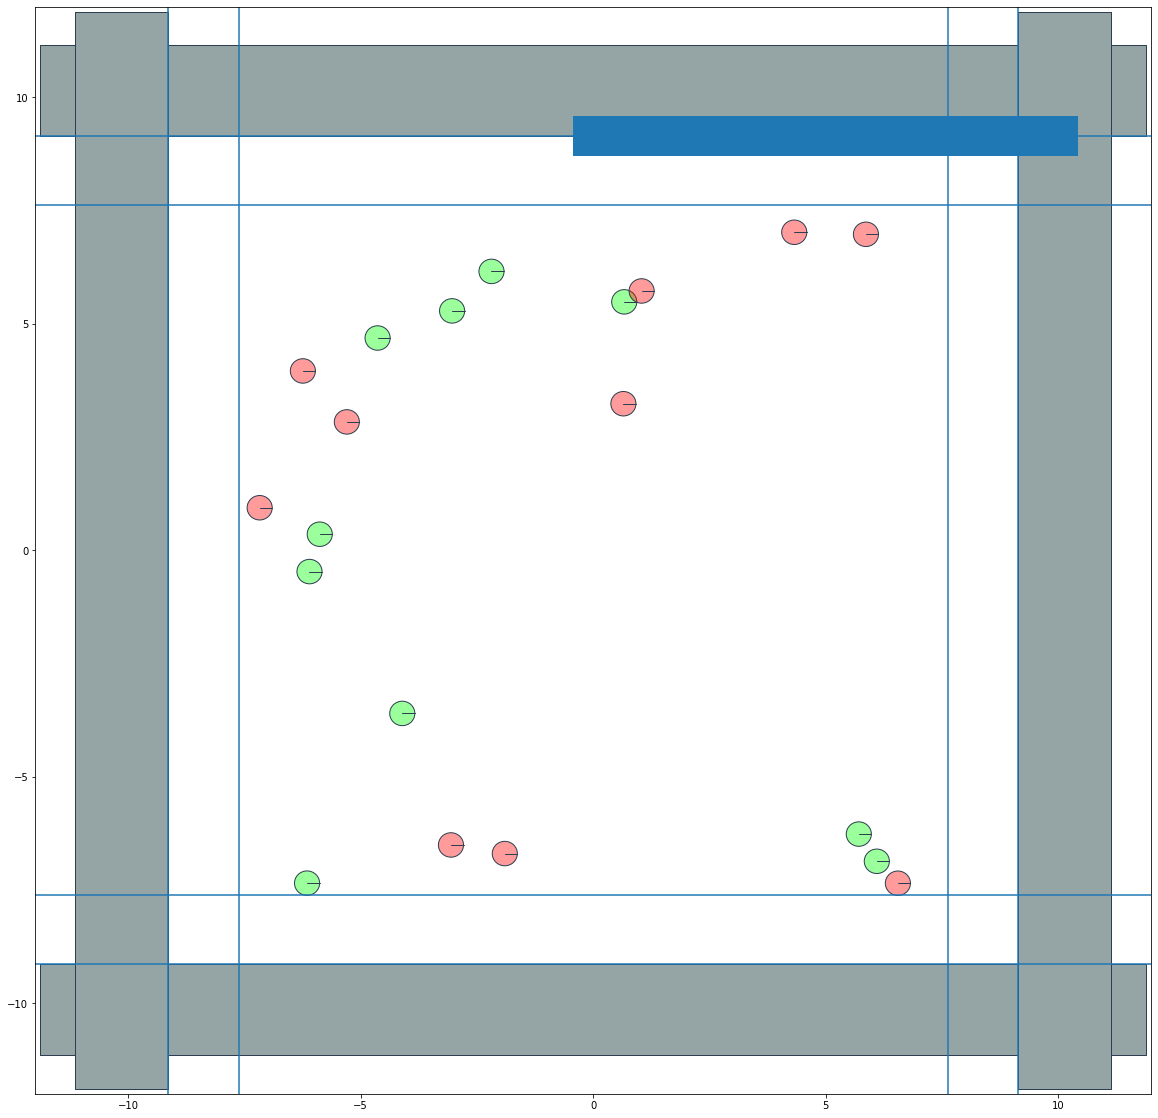

In [27]:
env = env_basketball.BasketballEnv(config={'n_offensive_players': 10, 'n_defensive_players': 10})
state = env.reset()
fig, ax = plt.subplots(figsize=(20, 20))
# ax.set_facecolor("red")
o = pymunk.matplotlib_util.DrawOptions(ax)
env.space.debug_draw(o)

plt.hlines(9.144, -20, 20); plt.hlines(-9.144, -20, 20); plt.vlines(9.144, -20, 20); plt.vlines(-9.144, -20, 20)
plt.hlines(7.62, -20, 20); plt.hlines(-7.62, -20, 20); plt.vlines(7.62, -20, 20); plt.vlines(-7.62, -20, 20)
plt.xlim(-12, 12)
plt.ylim(-12, 12)

plt.plot([0,10], [9.144, 9.144], linewidth=40)

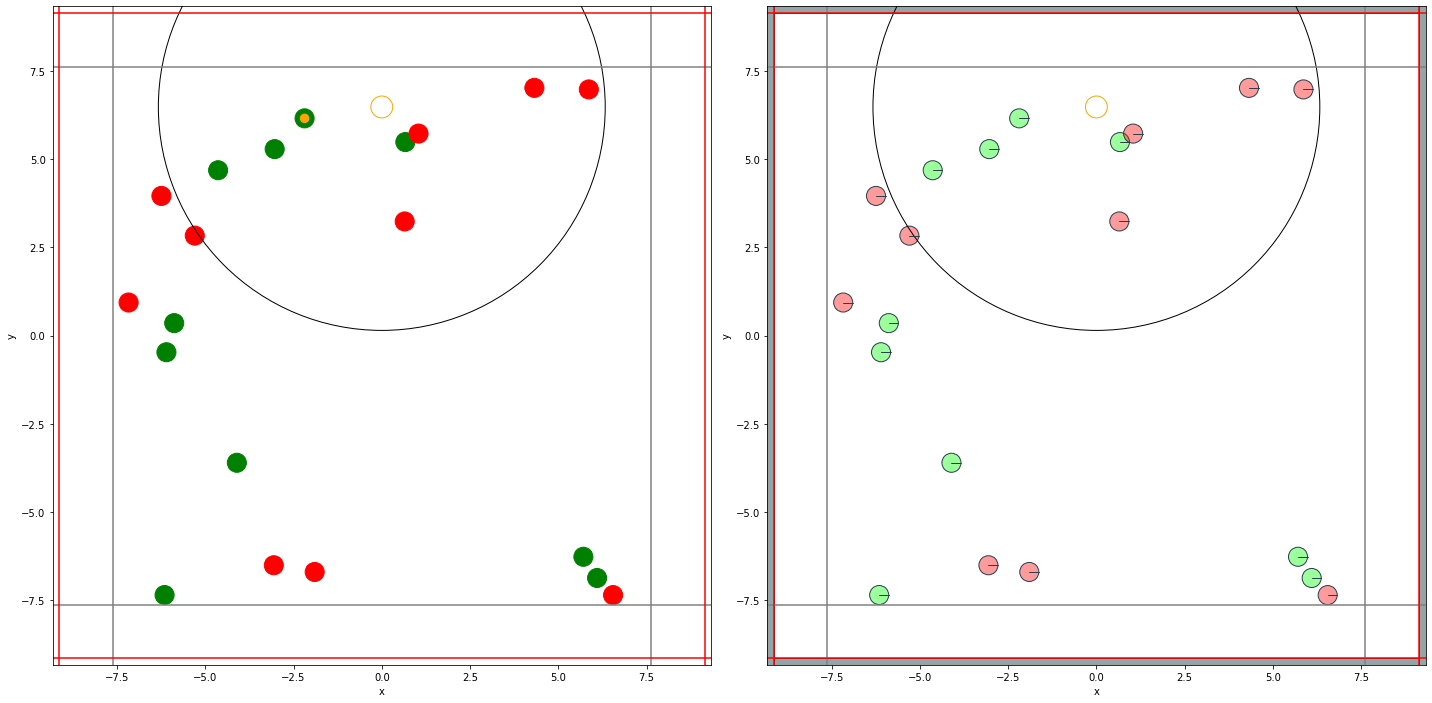

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
env.render(ax=axs[0])
env.render(backend='pymunk', ax=axs[1])
plt.tight_layout()
# plt.plot([0,10], [9.144, 9.144], linewidth=40)

In [326]:
player.stats['mass']

83

In [327]:
1/env.config['fps']*1000/player.stats['mass']

1.2048192771084338

In [330]:
env = env_basketball.BasketballEnv(config={'n_offensive_players': 1, 'n_defensive_players': 0})
state = env.reset()

for player in [env.players_offense[0]]:
    player.body.position = (0,0)
    player.body.force = (1000,0)
env.state = env.get_state()
env.states = [env.state]

for t in range(80):
    # print(player.body.force)
    print(player.body.velocity)
    action = env.action_space.sample()
    state, reward, done, info = env.step(env_basketball.get_random_action(env, env.state))

Vec2d(0.0, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.2048192771084338, 0.0)
Vec2d(1.204819277108433

In [331]:
ani, vid = env.render_episode()
# vid